**Name**: Anirudh Rao

**Roll No.**: BE21B004



---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We import the training set of the IDA2016 Challenge.

In [ ]:
df = pd.read_csv("aps_failure_training_set.csv")

In [ ]:
len(df)

60000

In [ ]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


We check the class imbalance of this dataset.

In [ ]:
df["class"].value_counts()

,count
class,
neg,59000
pos,1000


As mentioned in the question, there is an imbalance of 59:1 for neg:pos.

We also observe that there are many "na" values in the dataset. For ease of cleaning the data, we replace them with NumPy NaN values.

In [ ]:
df.replace("na",np.nan,inplace=True)

In [ ]:
df.isna().sum()

,0
class,0
aa_000,0
ab_000,46329
ac_000,3335
ad_000,14861
...,...
ee_007,671
ee_008,671
ee_009,671
ef_000,2724


We can see that many feature columns have NaN values. They will have to be cleaned. If the number of NaN values in  a column is more than 1000, we will discard that column.

In [ ]:
for column in df.columns:
    if df[column].isna().sum() > 1000:
        df.drop(column, axis=1, inplace=True)

In [ ]:
df.isna().sum()

,0
class,0
aa_000,0
ag_000,671
ag_001,671
ag_002,671
...,...
ee_005,671
ee_006,671
ee_007,671
ee_008,671


There are still some datapoints with NaN values. We will drop all those datapoint that contain at least 1 NaN value.

In [ ]:
df = df.dropna(axis=0, how="any")

In [ ]:
df.isna().sum()

,0
class,0
aa_000,0
ag_000,0
ag_001,0
ag_002,0
...,...
ee_005,0
ee_006,0
ee_007,0
ee_008,0


We have effectively cleaned the dataset and freed it from NaN values.

In [ ]:
len(df)

58127

In [ ]:
df["class"].value_counts()

,count
class,
neg,57198
pos,929


The number of datapoints has the same order of magnitude, as does the class imbalance.

# Task 1

We divide the dataset into a training set and testing set.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("class", axis=1), df["class"], test_size=0.3, random_state=5401)

To ensure the support vector algorithm to efficiently learn from the data, we will perform standard scaling.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We construct the base models for the three classification algorithms - SVC, Logistic Regression, and Decision Trees. We will perform 5-fold cross-validation to find their best hyperparameters. They will be train on the imbalanced dataset.

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
svc_params = {"kernel":["poly","rbf"],
              "gamma": ["scale", "auto"],
              "degree":[1, 2, 3]}

In [ ]:
logreg_params = {"penalty": ["l1", "l2"],
                 "C": [0.01, 0.1, 1]}

In [ ]:
tree_params = {"max_depth": [5, 10, None],
               "min_samples_leaf": [1, 2, 4]}

We run a grid search to find the best hyperparameters. This takes a while to run owing to the size of the dataset.

In [ ]:
svc_grid = GridSearchCV(SVC(), svc_params, cv=5, scoring="f1_macro", verbose=2)
logreg_grid = GridSearchCV(LogisticRegression(solver="liblinear"), logreg_params, cv=5, scoring="f1_macro", verbose=2)
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring="f1_macro", verbose=2)

print("Fitting SVC")
svc_grid.fit(X_train, y_train)
print("\nFitting Logistic Regression")
logreg_grid.fit(X_train, y_train)
print("\nFitting Decision Tree")
tree_grid.fit(X_train, y_train)

baseline_svc = svc_grid.best_estimator_
baseline_logreg = logreg_grid.best_estimator_
baseline_tree = tree_grid.best_estimator_

Fitting SVC
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................degree=1, gamma=scale, kernel=poly; total time=   3.6s
[CV] END .................degree=1, gamma=scale, kernel=poly; total time=   3.7s
[CV] END .................degree=1, gamma=scale, kernel=poly; total time=   3.5s
[CV] END .................degree=1, gamma=scale, kernel=poly; total time=   4.3s
[CV] END .................degree=1, gamma=scale, kernel=poly; total time=   3.5s
[CV] END ..................degree=1, gamma=scale, kernel=rbf; total time=   7.7s
[CV] END ..................degree=1, gamma=scale, kernel=rbf; total time=   7.3s
[CV] END ..................degree=1, gamma=scale, kernel=rbf; total time=   7.7s
[CV] END ..................degree=1, gamma=scale, kernel=rbf; total time=   6.8s
[CV] END ..................degree=1, gamma=scale, kernel=rbf; total time=   7.9s
[CV] END ..................degree=1, gamma=auto, kernel=poly; total time=   3.3s
[CV] END ..................degree=1,

We obtain the optimized hyperparameters and compute the baseline performance on the imbalanced dataset using macro-averaged F1-score as the metric.

In [ ]:
baseline_svc_params = svc_grid.best_params_
baseline_logreg_params = logreg_grid.best_params_
baseline_tree_params = tree_grid.best_params_

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
baseline_svc.fit(X_train, y_train)
baseline_logreg.fit(X_train, y_train)
baseline_tree.fit(X_train, y_train)

svc_train_score = f1_score(y_train, baseline_svc.predict(X_train), average="macro")
logreg_train_score = f1_score(y_train, baseline_logreg.predict(X_train), average="macro")
tree_train_score = f1_score(y_train, baseline_tree.predict(X_train), average="macro")

svc_test_score = f1_score(y_test, baseline_svc.predict(X_test), average="macro")
logreg_test_score = f1_score(y_test, baseline_logreg.predict(X_test), average="macro")
tree_test_score = f1_score(y_test, baseline_tree.predict(X_test), average="macro")

print(f"SVC train score: {svc_train_score}")
print(f"SVC test score: {svc_test_score}")
print(f"Logistic Regression train score: {logreg_train_score}")
print(f"Logistic Regression test score: {logreg_test_score}")
print(f"Decision Tree train score: {tree_train_score}")
print(f"Decision Tree test score: {tree_test_score}")

SVC train score: 0.9487467078627851
SVC test score: 0.8667468233242389
Logistic Regression train score: 0.8684941626785421
Logistic Regression test score: 0.8408095081608062
Decision Tree train score: 0.9529418840132171
Decision Tree test score: 0.8495030592427718


The classifiers actually perform decently on the imbalanced data. We will now use some sampling strategies to overcome the imbalance and obtain better performance.

# Task 2

To keep track of the class balance, we will use the `Counter` class from the `collections` library.

In [ ]:
from collections import Counter

In [ ]:
print(Counter(y_train))

Counter({'neg': 40036, 'pos': 652})


**Undersampling the majority class**

We will first undersample the majority class ('neg') to overcome the class imbalance. We can do so using the `RandomUnderSampler` class of the `imblearn` library.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
undersampler = RandomUnderSampler(random_state=5401, sampling_strategy="majority")
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
print(Counter(y_train_under))

Counter({'neg': 652, 'pos': 652})


The number of datapoints in the training set has been reduced due to the undersampling. We fit the 3 hyperparameter-optimized classification algorithms with this training data.

In [ ]:
svc_undersampling = SVC(**baseline_svc_params)
logreg_undersampling = LogisticRegression(**baseline_logreg_params, solver="liblinear")
tree_undersampling = DecisionTreeClassifier(**baseline_tree_params)

In [ ]:
svc_undersampling.fit(X_train_under, y_train_under)
logreg_undersampling.fit(X_train_under, y_train_under)
tree_undersampling.fit(X_train_under, y_train_under)

svc_undersampling_train_score = f1_score(y_train_under, svc_undersampling.predict(X_train_under), average="macro")
logreg_undersampling_train_score = f1_score(y_train_under, logreg_undersampling.predict(X_train_under), average="macro")
tree_undersampling_train_score = f1_score(y_train_under, tree_undersampling.predict(X_train_under), average="macro")

svc_undersampling_test_score = f1_score(y_test, svc_undersampling.predict(X_test), average="macro")
logreg_undersampling_test_score = f1_score(y_test, logreg_undersampling.predict(X_test), average="macro")
tree_undersampling_test_score = f1_score(y_test, tree_undersampling.predict(X_test), average="macro")

print(f"Undersampling SVC train score: {svc_undersampling_train_score}")
print(f"Undersampling SVC test score: {svc_undersampling_test_score}")
print(f"Undersampling Logistic Regression train score: {logreg_undersampling_train_score}")
print(f"Undersampling Logistic Regression test score: {logreg_undersampling_test_score}")
print(f"Undersampling Decision Tree train score: {tree_undersampling_train_score}")
print(f"Undersampling Decision Tree test score: {tree_undersampling_test_score}")

Undersampling SVC train score: 0.9646872932183873
Undersampling SVC test score: 0.7290021995766903
Undersampling Logistic Regression train score: 0.9654849314198293
Undersampling Logistic Regression test score: 0.6942524457760246
Undersampling Decision Tree train score: 0.9930978307215931
Undersampling Decision Tree test score: 0.6414801858050804


We will compare all the sampling strategies at the end.

**Oversampling the minority class**

We then oversample the minority class ('pos') to overcome the class imbalance. We can do so using the `RandomOverSampler` class of the `imblearn` library.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversampler = RandomOverSampler(random_state=5401, sampling_strategy="minority")
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
print(Counter(y_train_over))

Counter({'neg': 40036, 'pos': 40036})


The number of datapoints in the training set has been increased due to the oversampling. We fit the 3 hyperparameter-optimized classification algorithms with this training data.

In [ ]:
svc_oversampling = SVC(**baseline_svc_params)
logreg_oversampling = LogisticRegression(**baseline_logreg_params, solver="liblinear")
tree_oversampling = DecisionTreeClassifier(**baseline_tree_params)

In [ ]:
svc_oversampling.fit(X_train_over, y_train_over)
logreg_oversampling.fit(X_train_over, y_train_over)
tree_oversampling.fit(X_train_over, y_train_over)

svc_oversampling_train_score = f1_score(y_train_over, svc_oversampling.predict(X_train_over), average="macro")
logreg_oversampling_train_score = f1_score(y_train_over, logreg_oversampling.predict(X_train_over), average="macro")
tree_oversampling_train_score = f1_score(y_train_over, tree_oversampling.predict(X_train_over), average="macro")

svc_oversampling_test_score = f1_score(y_test, svc_oversampling.predict(X_test), average="macro")
logreg_oversampling_test_score = f1_score(y_test, logreg_oversampling.predict(X_test), average="macro")
tree_oversampling_test_score = f1_score(y_test, tree_oversampling.predict(X_test), average="macro")

print(f"Oversampling SVC train score: {svc_oversampling_train_score}")
print(f"Oversampling SVC test score: {svc_oversampling_test_score}")
print(f"Oversampling Logistic Regression train score: {logreg_oversampling_train_score}")
print(f"Oversampling Logistic Regression test score: {logreg_oversampling_test_score}")
print(f"Oversampling Decision Tree train score: {tree_oversampling_train_score}")
print(f"Oversampling Decision Tree test score: {tree_oversampling_test_score}")

Oversampling SVC train score: 0.9797386348597599
Oversampling SVC test score: 0.8302525916192145
Oversampling Logistic Regression train score: 0.962001942189947
Oversampling Logistic Regression test score: 0.7669832029733352
Oversampling Decision Tree train score: 0.9843755155880201
Oversampling Decision Tree test score: 0.7434434443515703


**Using `class_weight`**

We then use the `class_weight` parameter of the 3 algorithms to deal with the class imbalance. Setting it to '`balanced`' allows the algorithms to better classify the minority class.

In [ ]:
svc_class_weight = SVC(**baseline_svc_params, class_weight="balanced")
logreg_class_weight = LogisticRegression(**baseline_logreg_params, solver="liblinear", class_weight="balanced")
tree_class_weight = DecisionTreeClassifier(**baseline_tree_params, class_weight="balanced")

In [ ]:
svc_class_weight.fit(X_train, y_train)
logreg_class_weight.fit(X_train, y_train)
tree_class_weight.fit(X_train, y_train)

svc_class_train_score = f1_score(y_train, svc_class_weight.predict(X_train), average="macro")
logreg_class_train_score = f1_score(y_train, logreg_class_weight.predict(X_train), average="macro")
tree_class_train_score = f1_score(y_train, tree_class_weight.predict(X_train), average="macro")

svc_class_test_score = f1_score(y_test, svc_class_weight.predict(X_test), average="macro")
logreg_class_test_score = f1_score(y_test, logreg_class_weight.predict(X_test), average="macro")
tree_class_test_score = f1_score(y_test, tree_class_weight.predict(X_test), average="macro")

print(f"Class Weight SVC train score: {svc_class_train_score}")
print(f"Class Weight SVC test score: {svc_class_test_score}")
print(f"Class Weight Logistic Regression train score: {logreg_class_train_score}")
print(f"Class Weight Logistic Regression test score: {logreg_class_test_score}")
print(f"Class Weight Decision Tree train score: {tree_class_train_score}")
print(f"Class Weight Decision Tree test score: {tree_class_test_score}")

Class Weight SVC train score: 0.9039305766072113
Class Weight SVC test score: 0.829674868674819
Class Weight Logistic Regression train score: 0.7730223776731191
Class Weight Logistic Regression test score: 0.7682367938494301
Class Weight Decision Tree train score: 0.7905370485118826
Class Weight Decision Tree test score: 0.7463994007877692


**Using `sample_weights`**

The last method to deal with the imbalance is to attach more weight to the samples from the minority class. This can be done using `sklearn`'s `compute_sample_weight` function.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
sample_weights = compute_sample_weight("balanced", y_train)

In [ ]:
svc_sample_weights = SVC(**baseline_svc_params)
logreg_sample_weights = LogisticRegression(**baseline_logreg_params, solver="liblinear")
tree_sample_weights = DecisionTreeClassifier(**baseline_tree_params)

In [ ]:
svc_sample_weights.fit(X_train, y_train, sample_weight=sample_weights)
logreg_sample_weights.fit(X_train, y_train, sample_weight=sample_weights)
tree_sample_weights.fit(X_train, y_train, sample_weight=sample_weights)

svc_sample_train_score = f1_score(y_train, svc_sample_weights.predict(X_train), average="macro")
logreg_sample_train_score = f1_score(y_train, logreg_sample_weights.predict(X_train), average="macro")
tree_sample_train_score = f1_score(y_train, tree_sample_weights.predict(X_train), average="macro")

svc_sample_test_score = f1_score(y_test, svc_sample_weights.predict(X_test), average="macro")
logreg_sample_test_score = f1_score(y_test, logreg_sample_weights.predict(X_test), average="macro")
tree_sample_test_score = f1_score(y_test, tree_sample_weights.predict(X_test), average="macro")

print(f"Sample Weights SVC train score: {svc_sample_train_score}")
print(f"Sample Weights SVC test score: {svc_sample_test_score}")
print(f"Sample Weights Logistic Regression train score: {logreg_sample_train_score}")
print(f"Sample Weights Logistic Regression test score: {logreg_sample_test_score}")
print(f"Sample Weights Decision Tree train score: {tree_sample_train_score}")
print(f"Sample Weights Decision Tree test score: {tree_sample_test_score}")

Sample Weights SVC train score: 0.9039305766072113
Sample Weights SVC test score: 0.829674868674819
Sample Weights Logistic Regression train score: 0.7730223776731191
Sample Weights Logistic Regression test score: 0.7672956265348699
Sample Weights Decision Tree train score: 0.7906794652380246
Sample Weights Decision Tree test score: 0.7469252148215904


**Visualising the performance**

We then visualise the performance of all the sampling strategies using the training set.

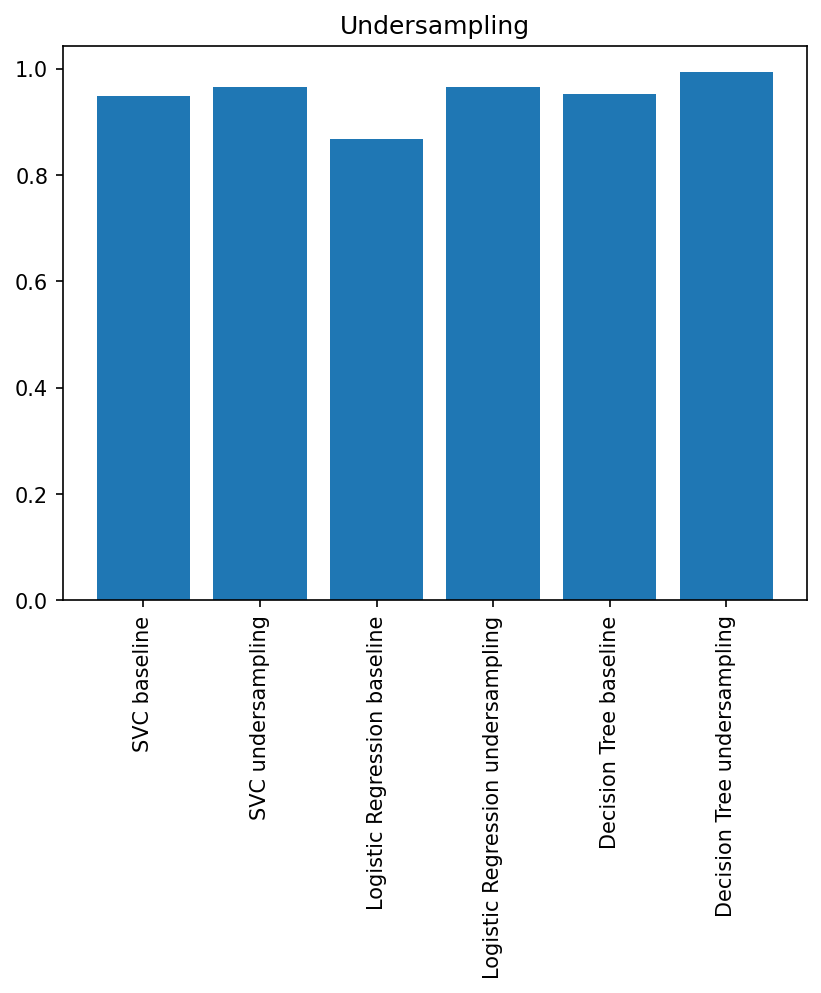

In [ ]:
plt.figure(dpi=150)
plt.title("Undersampling")
plt.bar(["SVC baseline","SVC undersampling","Logistic Regression baseline","Logistic Regression undersampling","Decision Tree baseline","Decision Tree undersampling"],
        [svc_train_score, svc_undersampling_train_score, logreg_train_score, logreg_undersampling_train_score, tree_train_score, tree_undersampling_train_score])
plt.xticks(rotation=90)
plt.show()

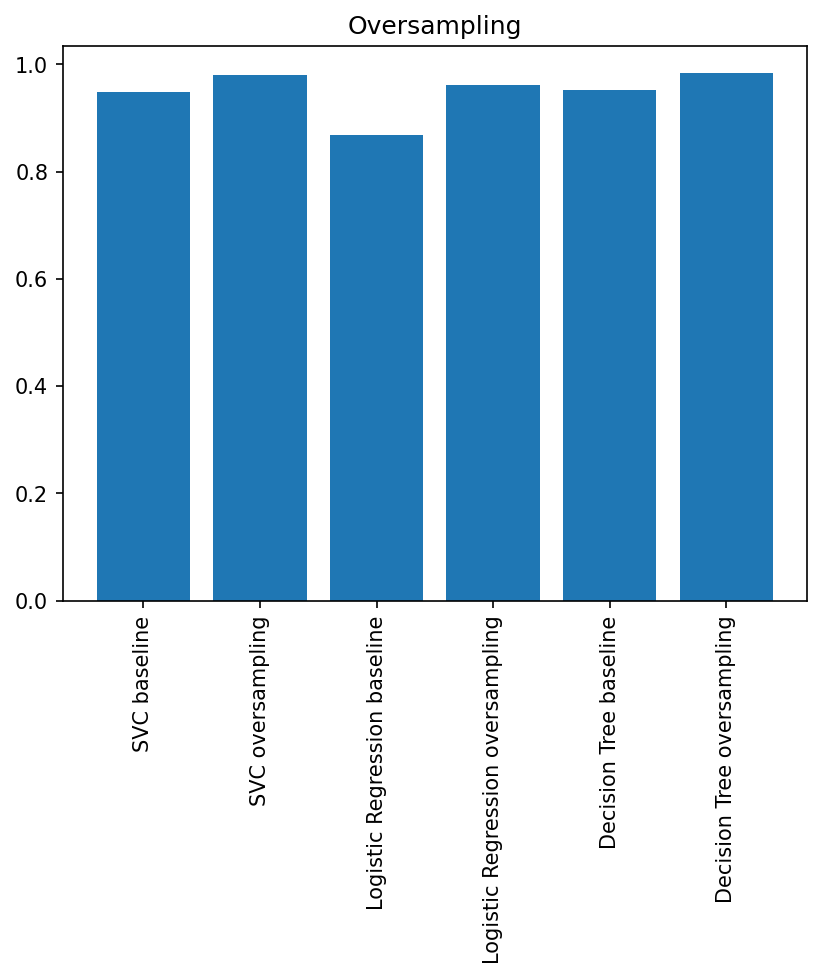

In [ ]:
plt.figure(dpi=150)
plt.title("Oversampling")
plt.bar(["SVC baseline","SVC oversampling","Logistic Regression baseline","Logistic Regression oversampling","Decision Tree baseline","Decision Tree oversampling"],
        [svc_train_score, svc_oversampling_train_score, logreg_train_score, logreg_oversampling_train_score, tree_train_score, tree_oversampling_train_score])
plt.xticks(rotation=90)
plt.show()

Both undersampling and oversampling achieve better training performance for all 3 algorithms than when the imbalanced dataset is used directly.

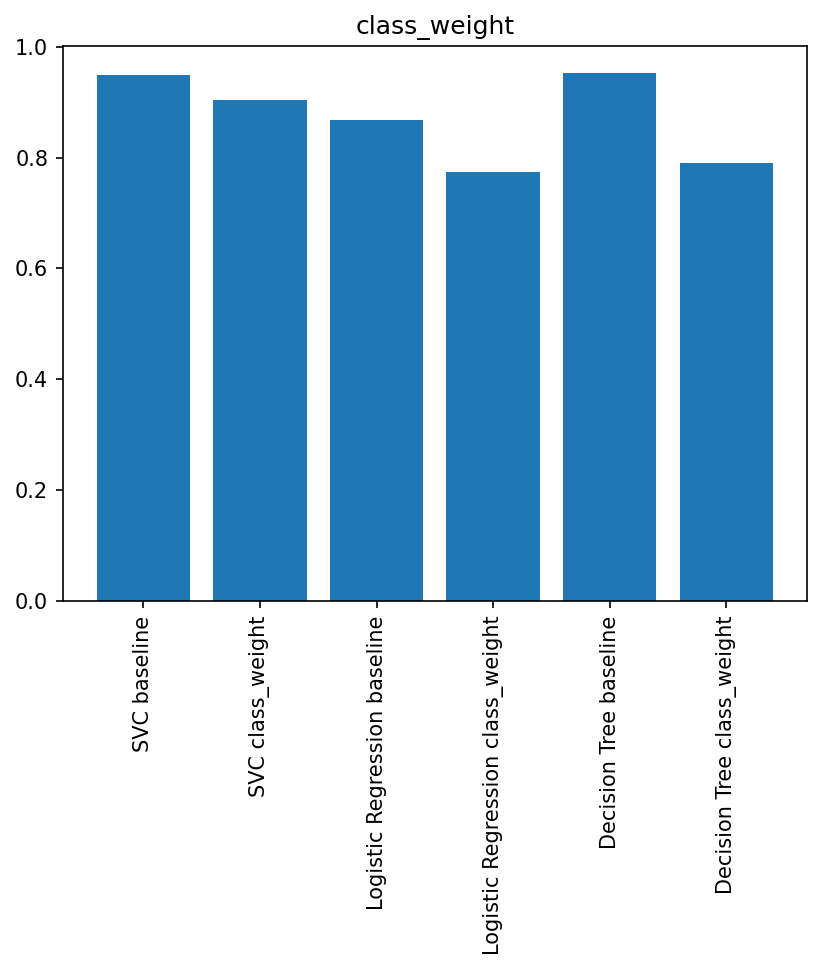

In [ ]:
plt.figure(dpi=150)
plt.title("class_weight")
plt.bar(["SVC baseline","SVC class_weight","Logistic Regression baseline","Logistic Regression class_weight","Decision Tree baseline","Decision Tree class_weight"],
        [svc_train_score, svc_class_train_score, logreg_train_score, logreg_class_train_score, tree_train_score, tree_class_train_score])
plt.xticks(rotation=90)
plt.show()

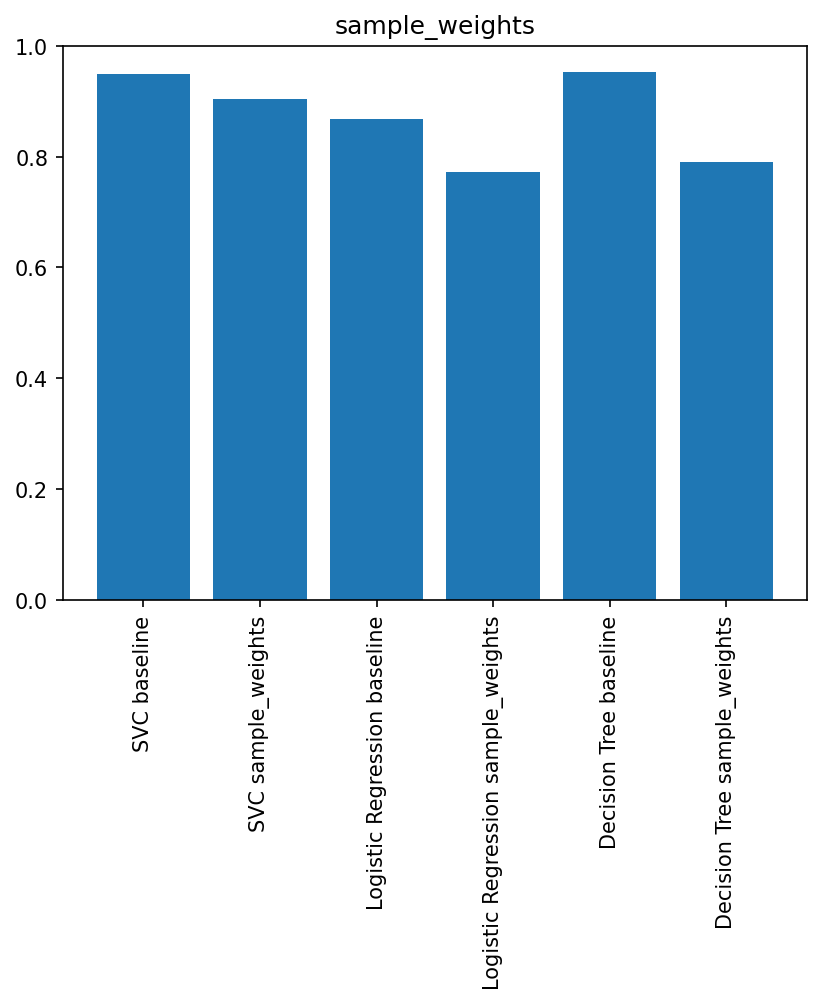

In [ ]:
plt.figure(dpi=150)
plt.title("sample_weights")
plt.bar(["SVC baseline","SVC sample_weights","Logistic Regression baseline","Logistic Regression sample_weights","Decision Tree baseline","Decision Tree sample_weights"],
        [svc_train_score, svc_sample_train_score, logreg_train_score, logreg_sample_train_score, tree_train_score, tree_sample_train_score])
plt.xticks(rotation=90)
plt.show()

Both class weights and sample weights achieve poorer training performance for all 3 algorithms than when the imbalanced dataset is used directly.

Thus, we can conclude that oversampling or undersampling are better strategies to deal with the class imbalance of the given dataset.